In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial
from collections import OrderedDict, defaultdict

from datasets import load_dataset
from more_itertools import chunked
from tqdm.auto import tqdm
import torch as t
import numpy as np

t.set_grad_enabled(False)

In [2]:
import gc

def free_unused_cuda_memory():
    gc.collect()
    if t.cuda.is_available():
        if t.cuda.device_count() > 1:
            t.cuda.synchronize()
        t.cuda.empty_cache()
    else:
        raise RuntimeError("CUDA not found!")

## FLUX.1 Schnell

In [3]:
from diffusers import FluxPipeline

pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=t.bfloat16, device_map="balanced")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
prompts_dataset = load_dataset("opendiffusionai/cc12m-cleaned", split="train").select(range(128))
prompts_iter = prompts_dataset["caption_llava_short"]

guidance_scale = 3.5
num_inference_steps = 1
batch_size = 32
width = 512
height = 512
d_model = 3072

num_layers = len(pipe.transformer.transformer_blocks)
text_outputs = [[] for _ in range(num_layers)]
image_outputs = [[] for _ in range(num_layers)] 

for i, prompts in enumerate(chunked((bar := tqdm(prompts_iter)), batch_size)):
    with t.inference_mode():
        for m in pipe.transformer.modules():
            m._forward_hooks = OrderedDict()

        timestep = 0

        def save_hook(self, input, output, l):
            text_outputs[l].append(output[0])
            image_outputs[l].append(output[1])  
            # if timestep in text_outputs[l] and isinstance(text_outputs[l][timestep], t.Tensor):
            #     text_outputs[l][timestep] = t.cat([text_outputs[l][timestep], output[0]])
            #     image_outputs[l][timestep] = t.cat([image_outputs[l][timestep], output[1]])
            # else:
            #     text_outputs[l][timestep] = output[0]
            #     image_outputs[l][timestep] = output[1]
        
        def callback_on_step_end(self, i, t, kwargs):
            global timestep
            timestep = i
            return {}

        for l in range(len(pipe.transformer.transformer_blocks)):
            pipe.transformer.transformer_blocks[l].register_forward_hook(partial(save_hook, l=l))

        pipe.set_progress_bar_config(disable=True) 
        with t.inference_mode():
            latents = pipe(
                prompts,
                height=height,
                width=width,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps,
                max_sequence_length=512,
                generator=t.Generator("cpu").manual_seed(0),
                return_dict=False,
                callback_on_step_end=callback_on_step_end,
                output_type="latent",
            )[0]

  0%|          | 0/128 [00:00<?, ?it/s]

In [5]:
text_layer_res = t.stack([t.stack(layer) for layer in text_outputs])
image_layer_res = t.stack([t.stack(layer) for layer in image_outputs])
del text_outputs, image_outputs
free_unused_cuda_memory()

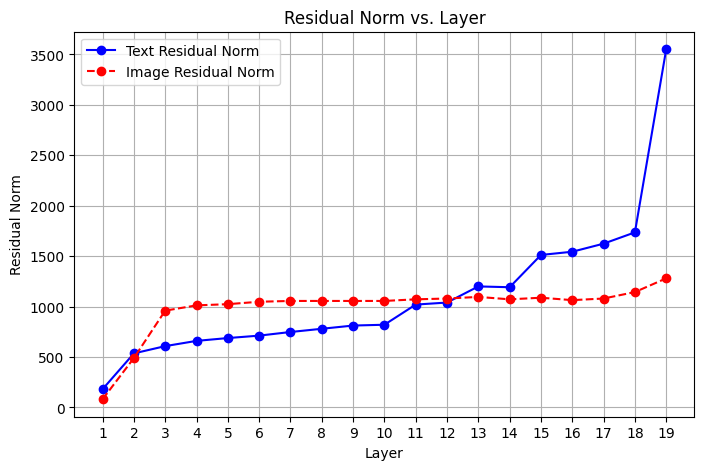

In [ ]:
import matplotlib.pyplot as plt

text_layer_res_norm = t.norm(text_layer_res, dim=-1, p=2).mean((-1, -2)).to(t.float32).cpu()
image_layer_res_norm = t.norm(image_layer_res, dim=-1, p=2).mean((-1, -2)).to(t.float32).cpu()
x_values = np.arange(text_layer_res_norm.shape[0]) + 1

plt.figure(figsize=(8, 5))
plt.plot(x_values, text_layer_res_norm, marker='o', linestyle='-', label="Text Residual Norm", color='b')
plt.plot(x_values, image_layer_res_norm, marker='o', linestyle='--', label="Image Residual Norm", color='r')

plt.xlabel("Layer")
plt.ylabel("Residual Norm")
plt.title("Residual Norm vs. Layer")

plt.xticks(x_values)

plt.legend()
plt.grid(True)

plt.show()

In [ ]:
del text_layer_res_norm, image_layer_res_norm
free_unused_cuda_memory()

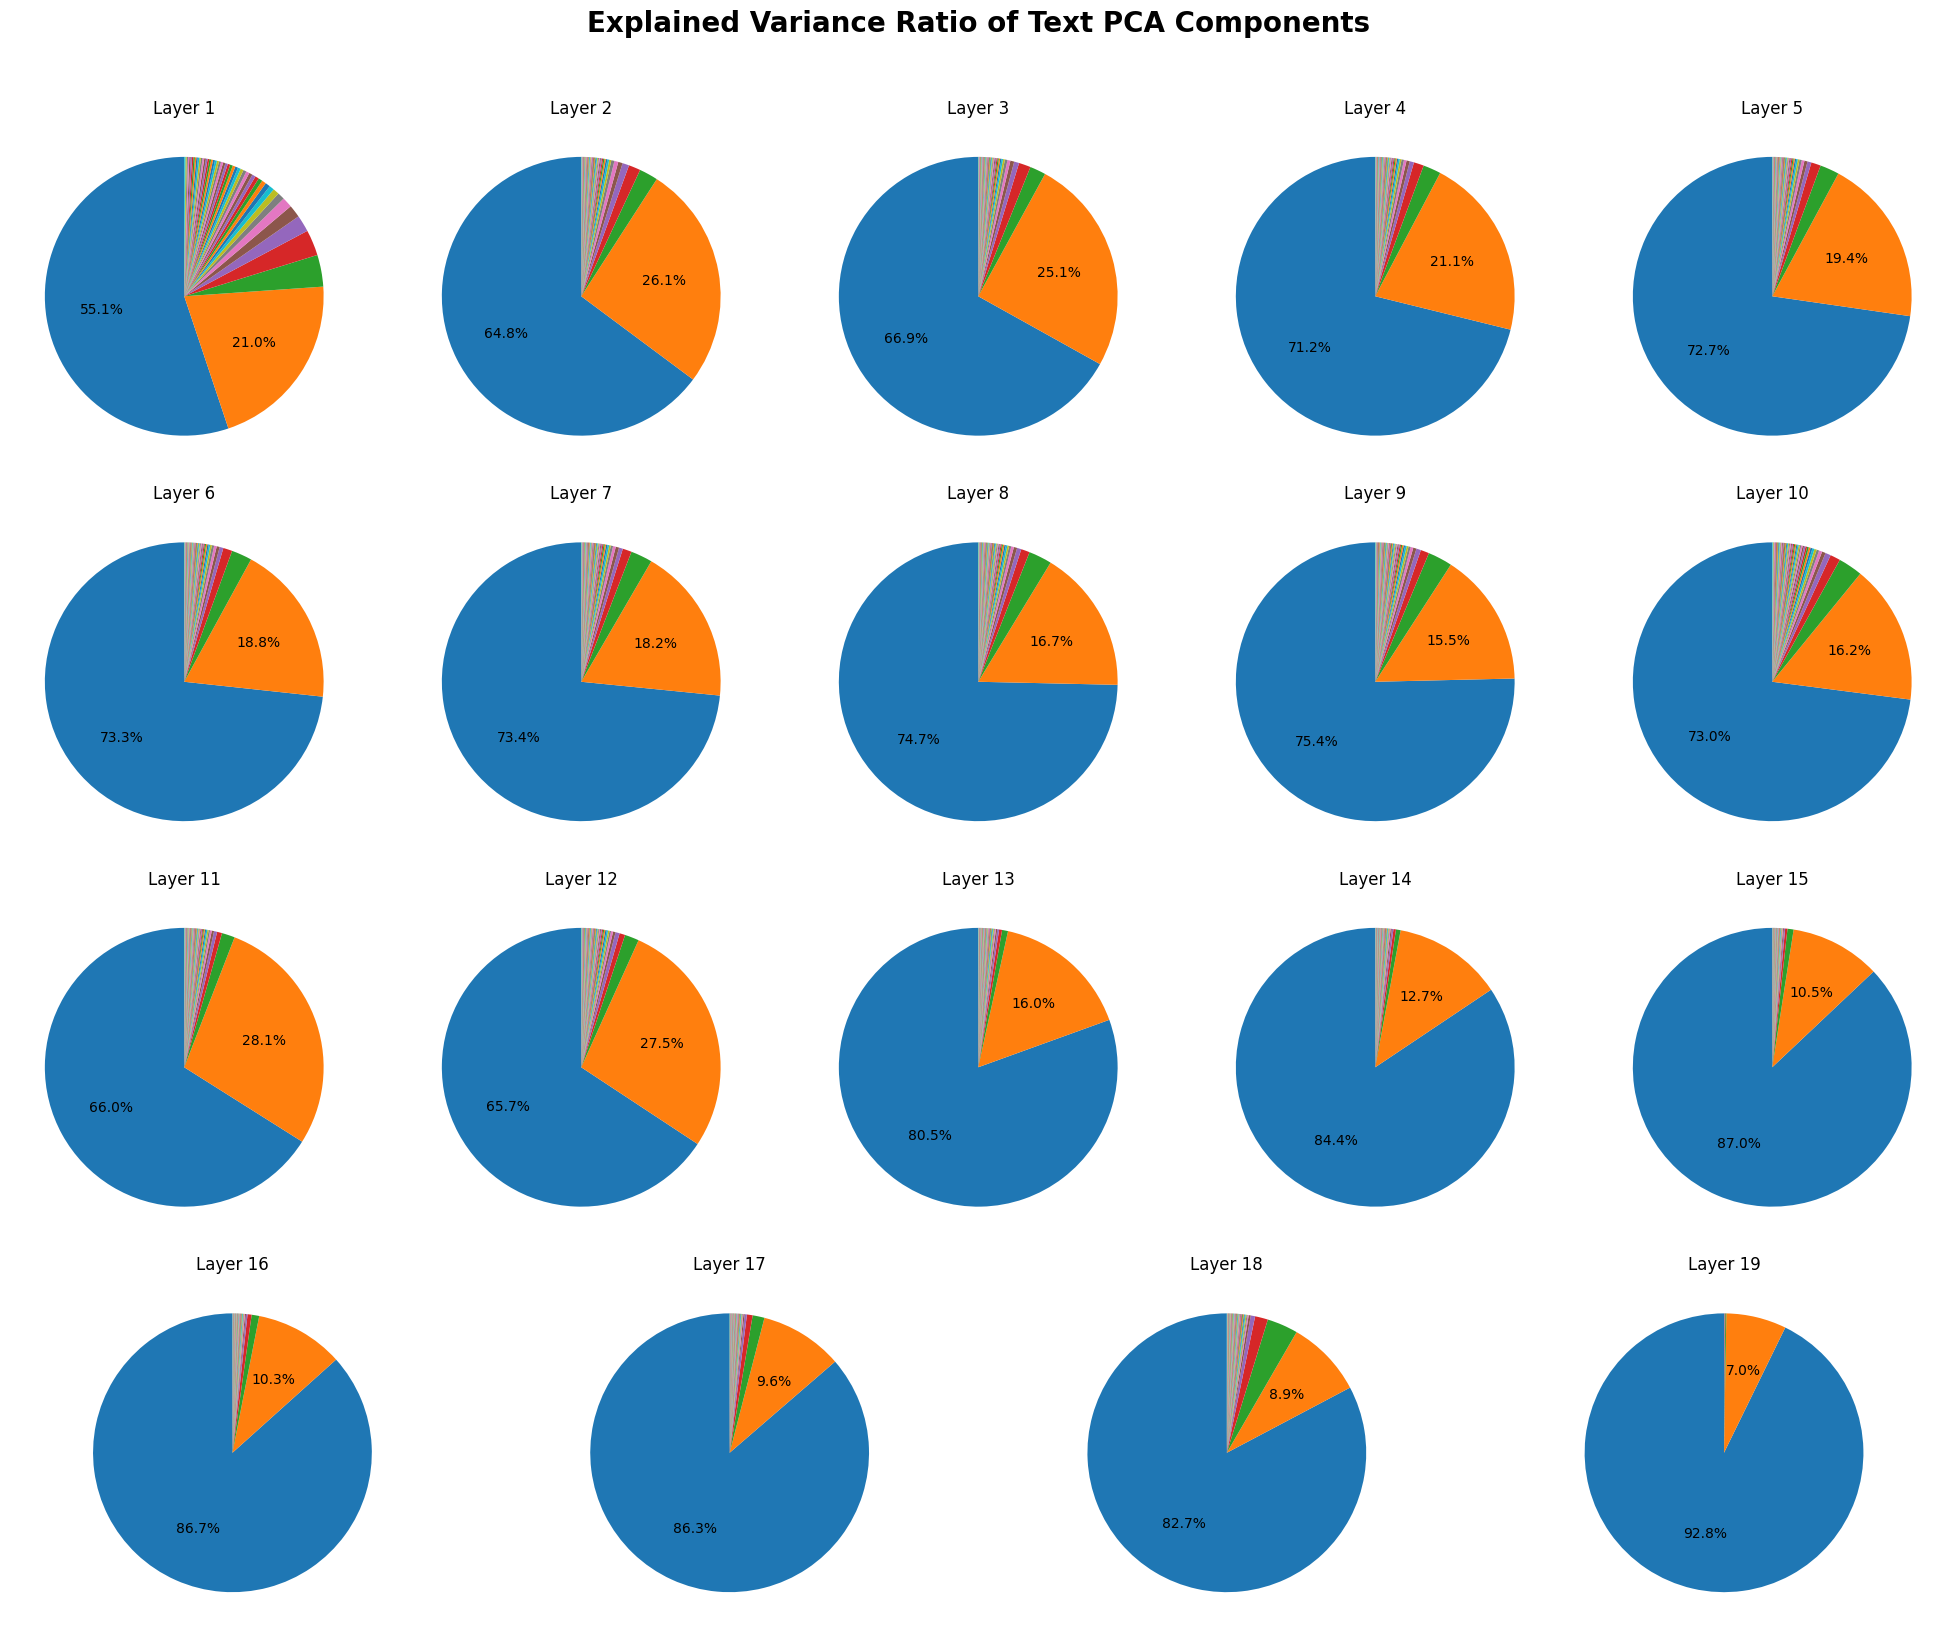

In [ ]:
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA

threshold = 5.0

def autopct_func(pct):
    return f"{pct:.1f}%" if pct > threshold else ''

fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(4, 5, figure=fig)

for i in range(15):
    text_pca = PCA(n_components=50)
    text_select = text_layer_res[i].reshape(-1, text_layer_res.shape[-1]).to(t.float32).cpu().numpy()
    text_pca.fit(text_select)

    ax = fig.add_subplot(gs[i // 5, i % 5])
    ax.pie(text_pca.explained_variance_ratio_, labels=None, autopct=autopct_func, startangle=90)
    ax.set_title(f'Layer {i+1}')

    del text_select
    free_unused_cuda_memory()

last_row = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[3, 0:5])

for i in range(15, len(text_layer_res)):  
    text_pca = PCA(n_components=50)
    text_select = text_layer_res[i].reshape(-1, text_layer_res.shape[-1]).to(t.float32).cpu().numpy()
    text_pca.fit(text_select)

    ax = fig.add_subplot(last_row[0, i - 15])
    ax.pie(text_pca.explained_variance_ratio_, labels=None, autopct=autopct_func, startangle=90)
    ax.set_title(f'Layer {i+1}')

    del text_select
    free_unused_cuda_memory()

fig.suptitle('Explained Variance Ratio of Text PCA Components', fontsize=20, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

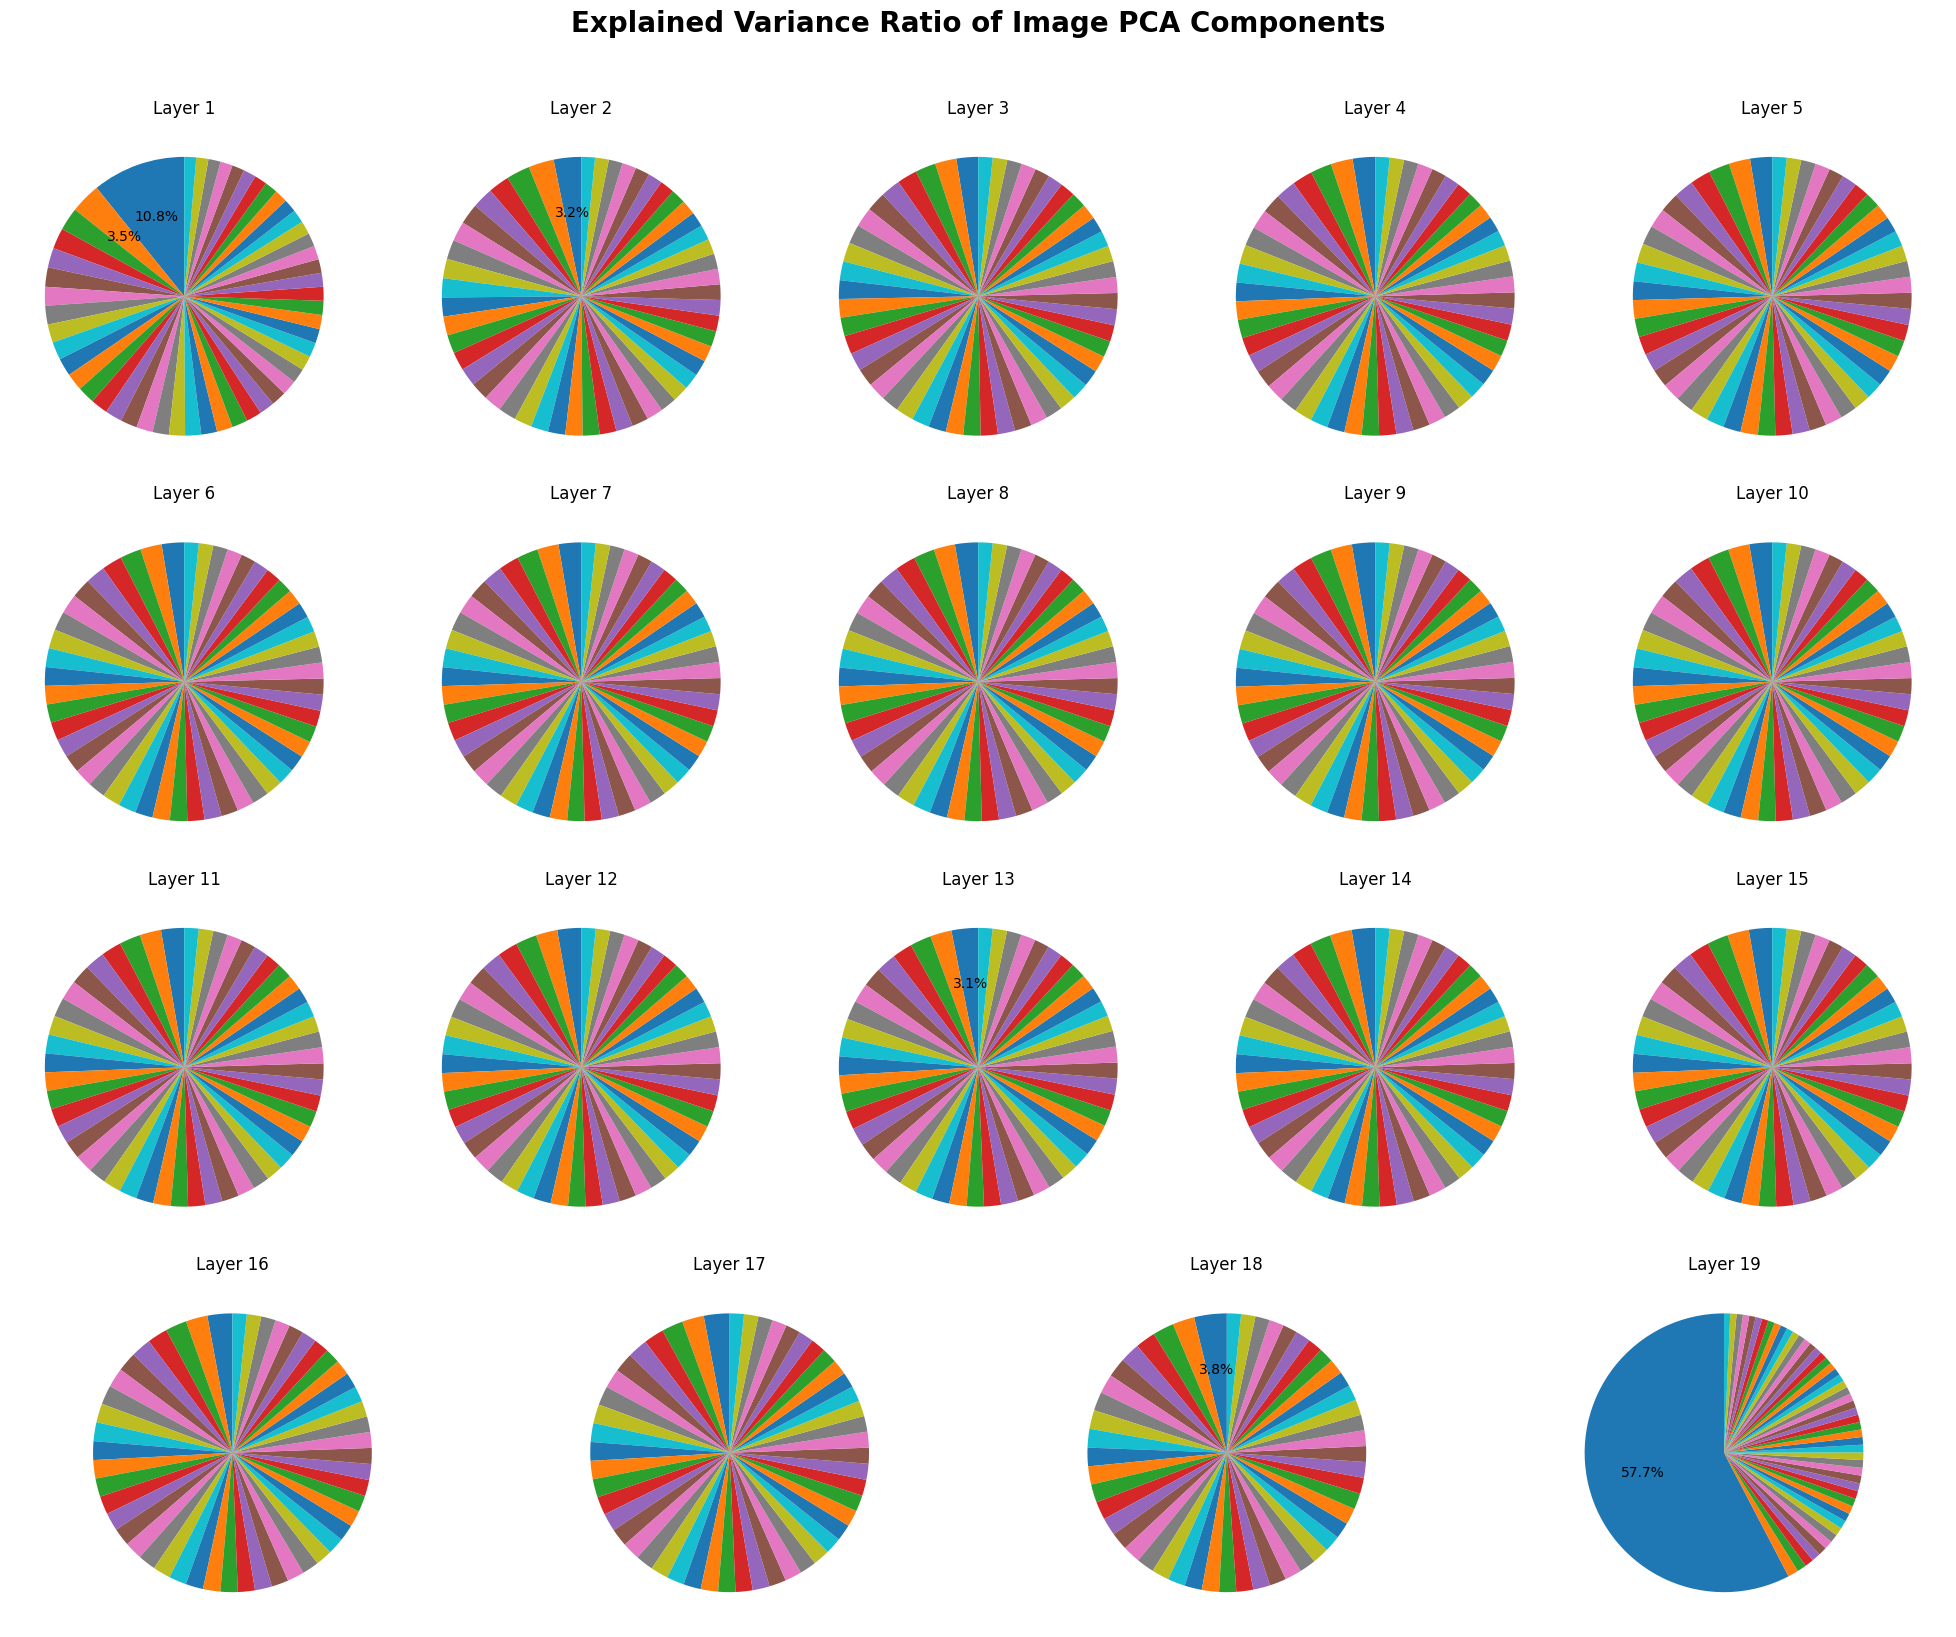

In [ ]:
threshold = 3.0

def autopct_func(pct):
    return f"{pct:.1f}%" if pct > threshold else ''

fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(4, 5, figure=fig)

for i in range(15):
    image_pca = PCA(n_components=50)
    image_select = image_layer_res[i].reshape(-1, image_layer_res.shape[-1]).to(t.float32).cpu().numpy()
    image_pca.fit(image_select)

    ax = fig.add_subplot(gs[i // 5, i % 5])
    ax.pie(image_pca.explained_variance_ratio_, labels=None, autopct=autopct_func, startangle=90)
    ax.set_title(f'Layer {i+1}')

    del image_select
    free_unused_cuda_memory()

last_row = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[3, 0:5])

for i in range(15, len(text_layer_res)):  
    image_pca = PCA(n_components=50)
    image_select = image_layer_res[i].reshape(-1, image_layer_res.shape[-1]).to(t.float32).cpu().numpy()
    image_pca.fit(image_select)

    ax = fig.add_subplot(last_row[0, i - 15])
    ax.pie(image_pca.explained_variance_ratio_, labels=None, autopct=autopct_func, startangle=90)
    ax.set_title(f'Layer {i+1}')

    del image_select
    free_unused_cuda_memory()

fig.suptitle('Explained Variance Ratio of Image PCA Components', fontsize=20, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

In [20]:
text_layer_res.shape

torch.Size([19, 128, 512, 3072])

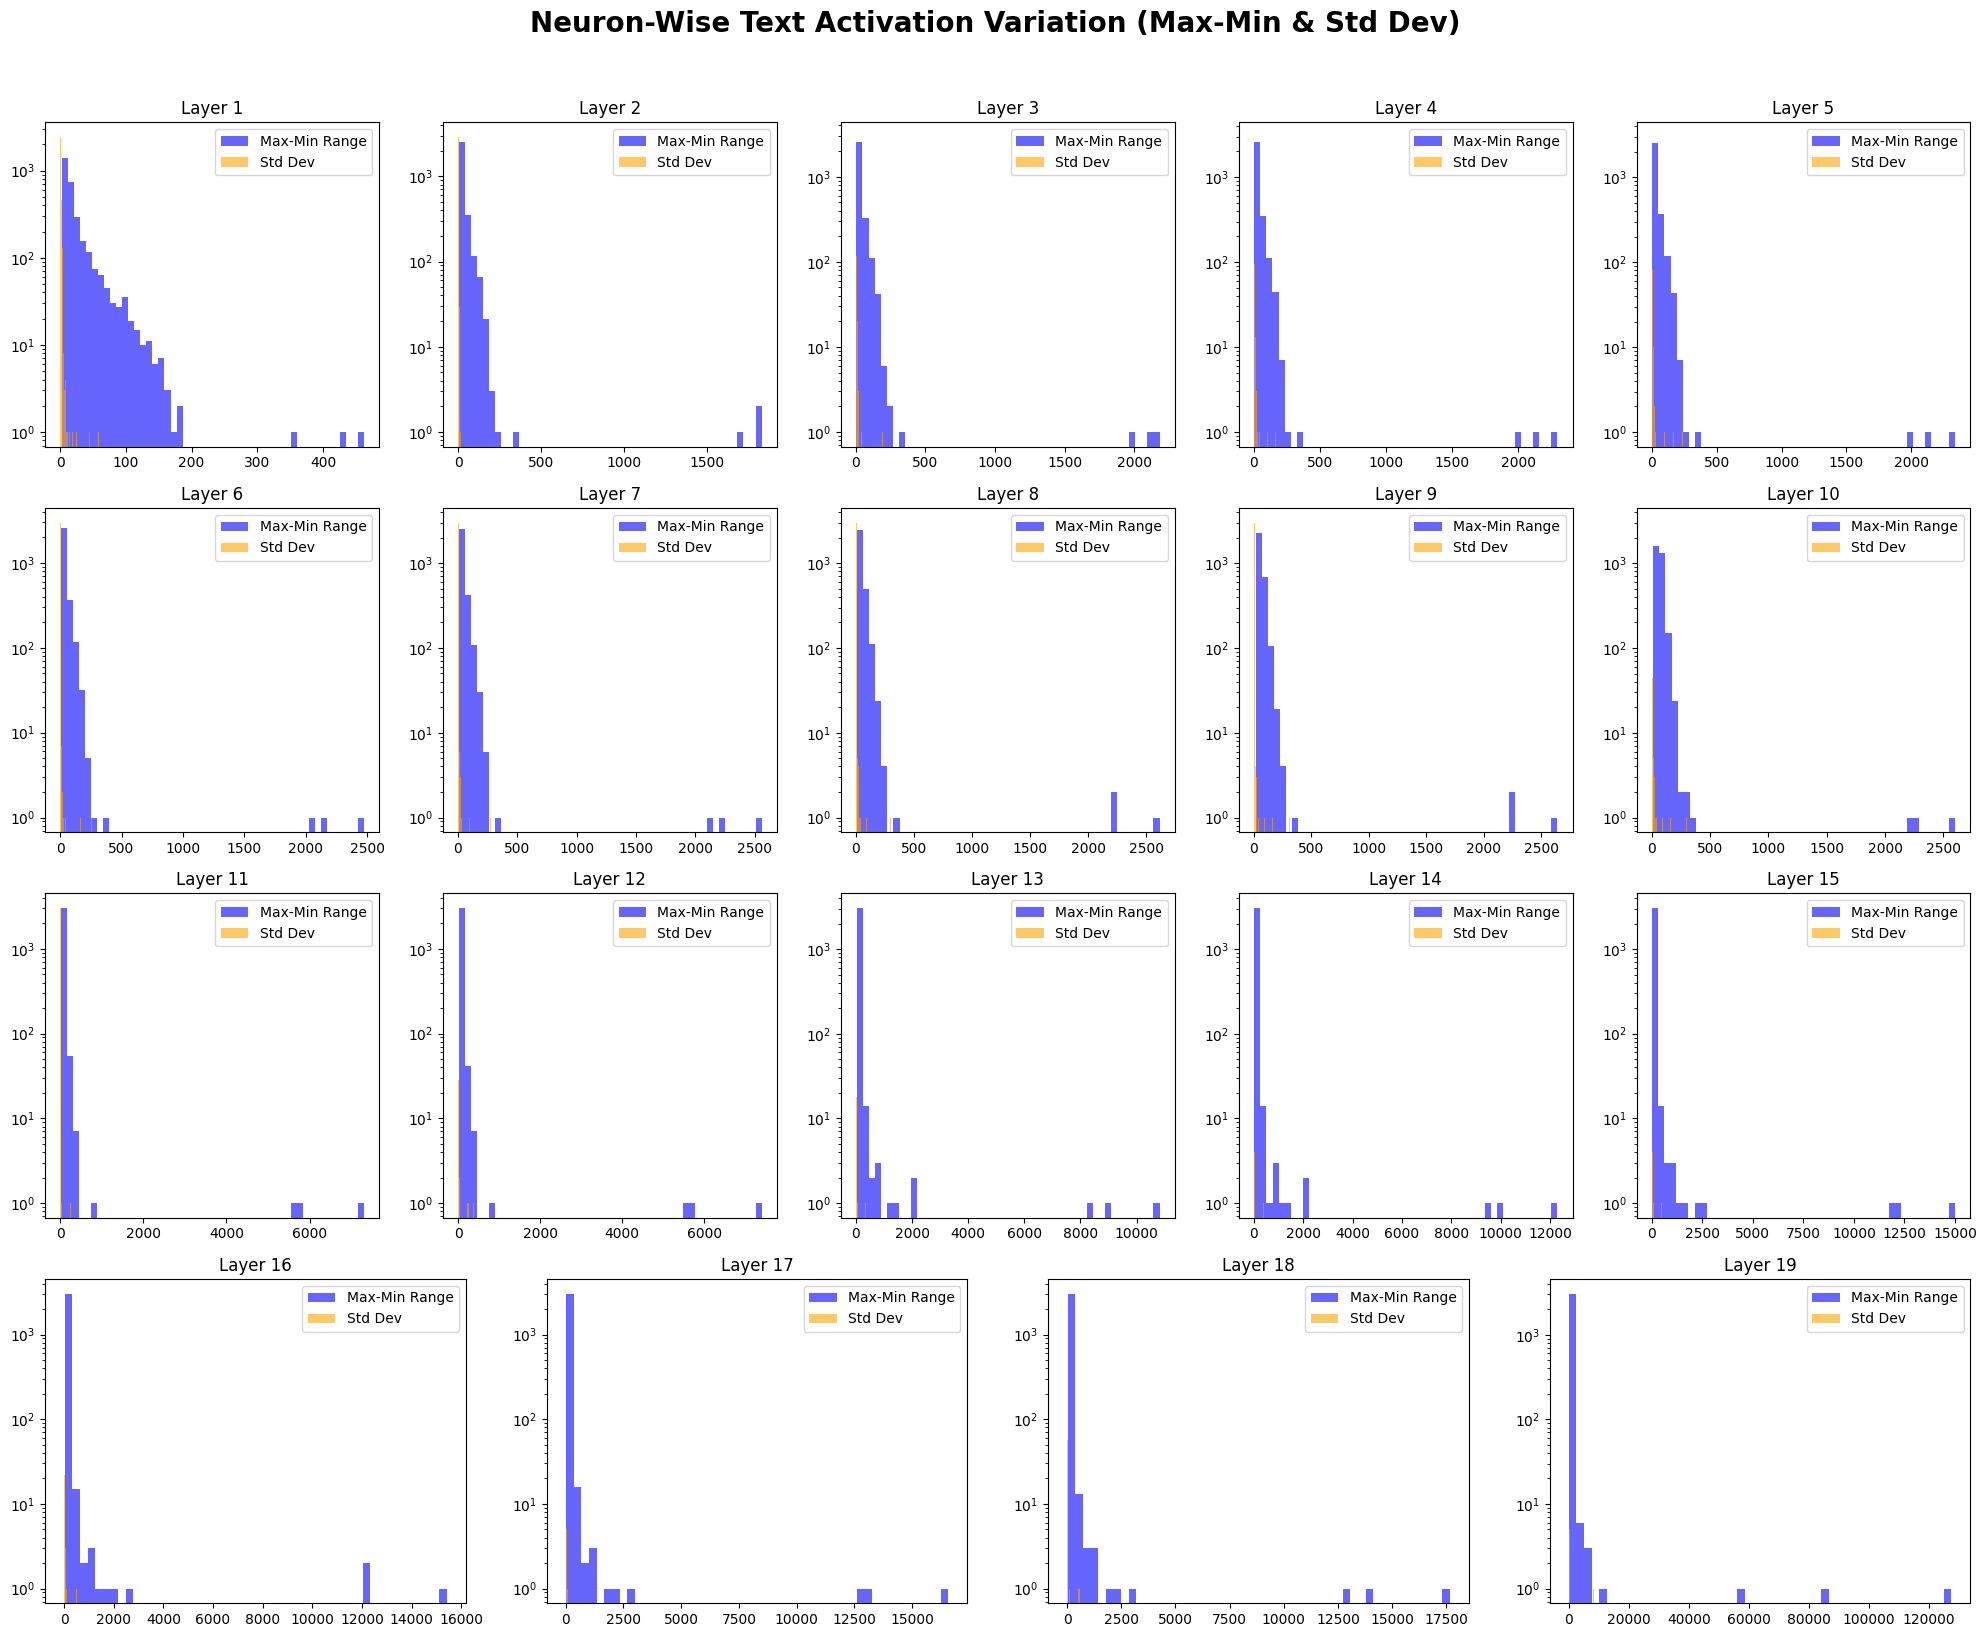

In [22]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(4, 5, figure=fig)

for i in range(15):
    text_select = text_layer_res[i].reshape(-1, text_layer_res.shape[-1]).to(t.float32).cpu().numpy()
    
    max_min_range = text_select.max(axis=0) - text_select.min(axis=0)
    std_dev = text_select.std(axis=0)

    ax = fig.add_subplot(gs[i // 5, i % 5])
    ax.hist(max_min_range, bins=50, alpha=0.6, label="Max-Min Range", color='blue', log=True)
    ax.hist(std_dev, bins=50, alpha=0.6, label="Std Dev", color='orange', log=True)
    ax.set_yscale('log')
    ax.set_title(f'Layer {i+1}')
    ax.legend()

    del text_select
    free_unused_cuda_memory()

last_row = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[3, 0:5])

for i in range(15, len(text_layer_res)):  
    text_select = text_layer_res[i].reshape(-1, text_layer_res.shape[-1]).to(t.float32).cpu().numpy()
    
    max_min_range = text_select.max(axis=0) - text_select.min(axis=0)
    std_dev = text_select.std(axis=0)

    ax = fig.add_subplot(last_row[0, i - 15])
    ax.hist(max_min_range, bins=50, alpha=0.6, label="Max-Min Range", color='blue', log=True)
    ax.hist(std_dev, bins=50, alpha=0.6, label="Std Dev", color='orange', log=True)
    ax.set_yscale('log')
    ax.set_title(f'Layer {i+1}')
    ax.legend()

    del text_select
    free_unused_cuda_memory()

fig.suptitle('Neuron-Wise Text Activation Variation (Max-Min & Std Dev)', fontsize=20, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

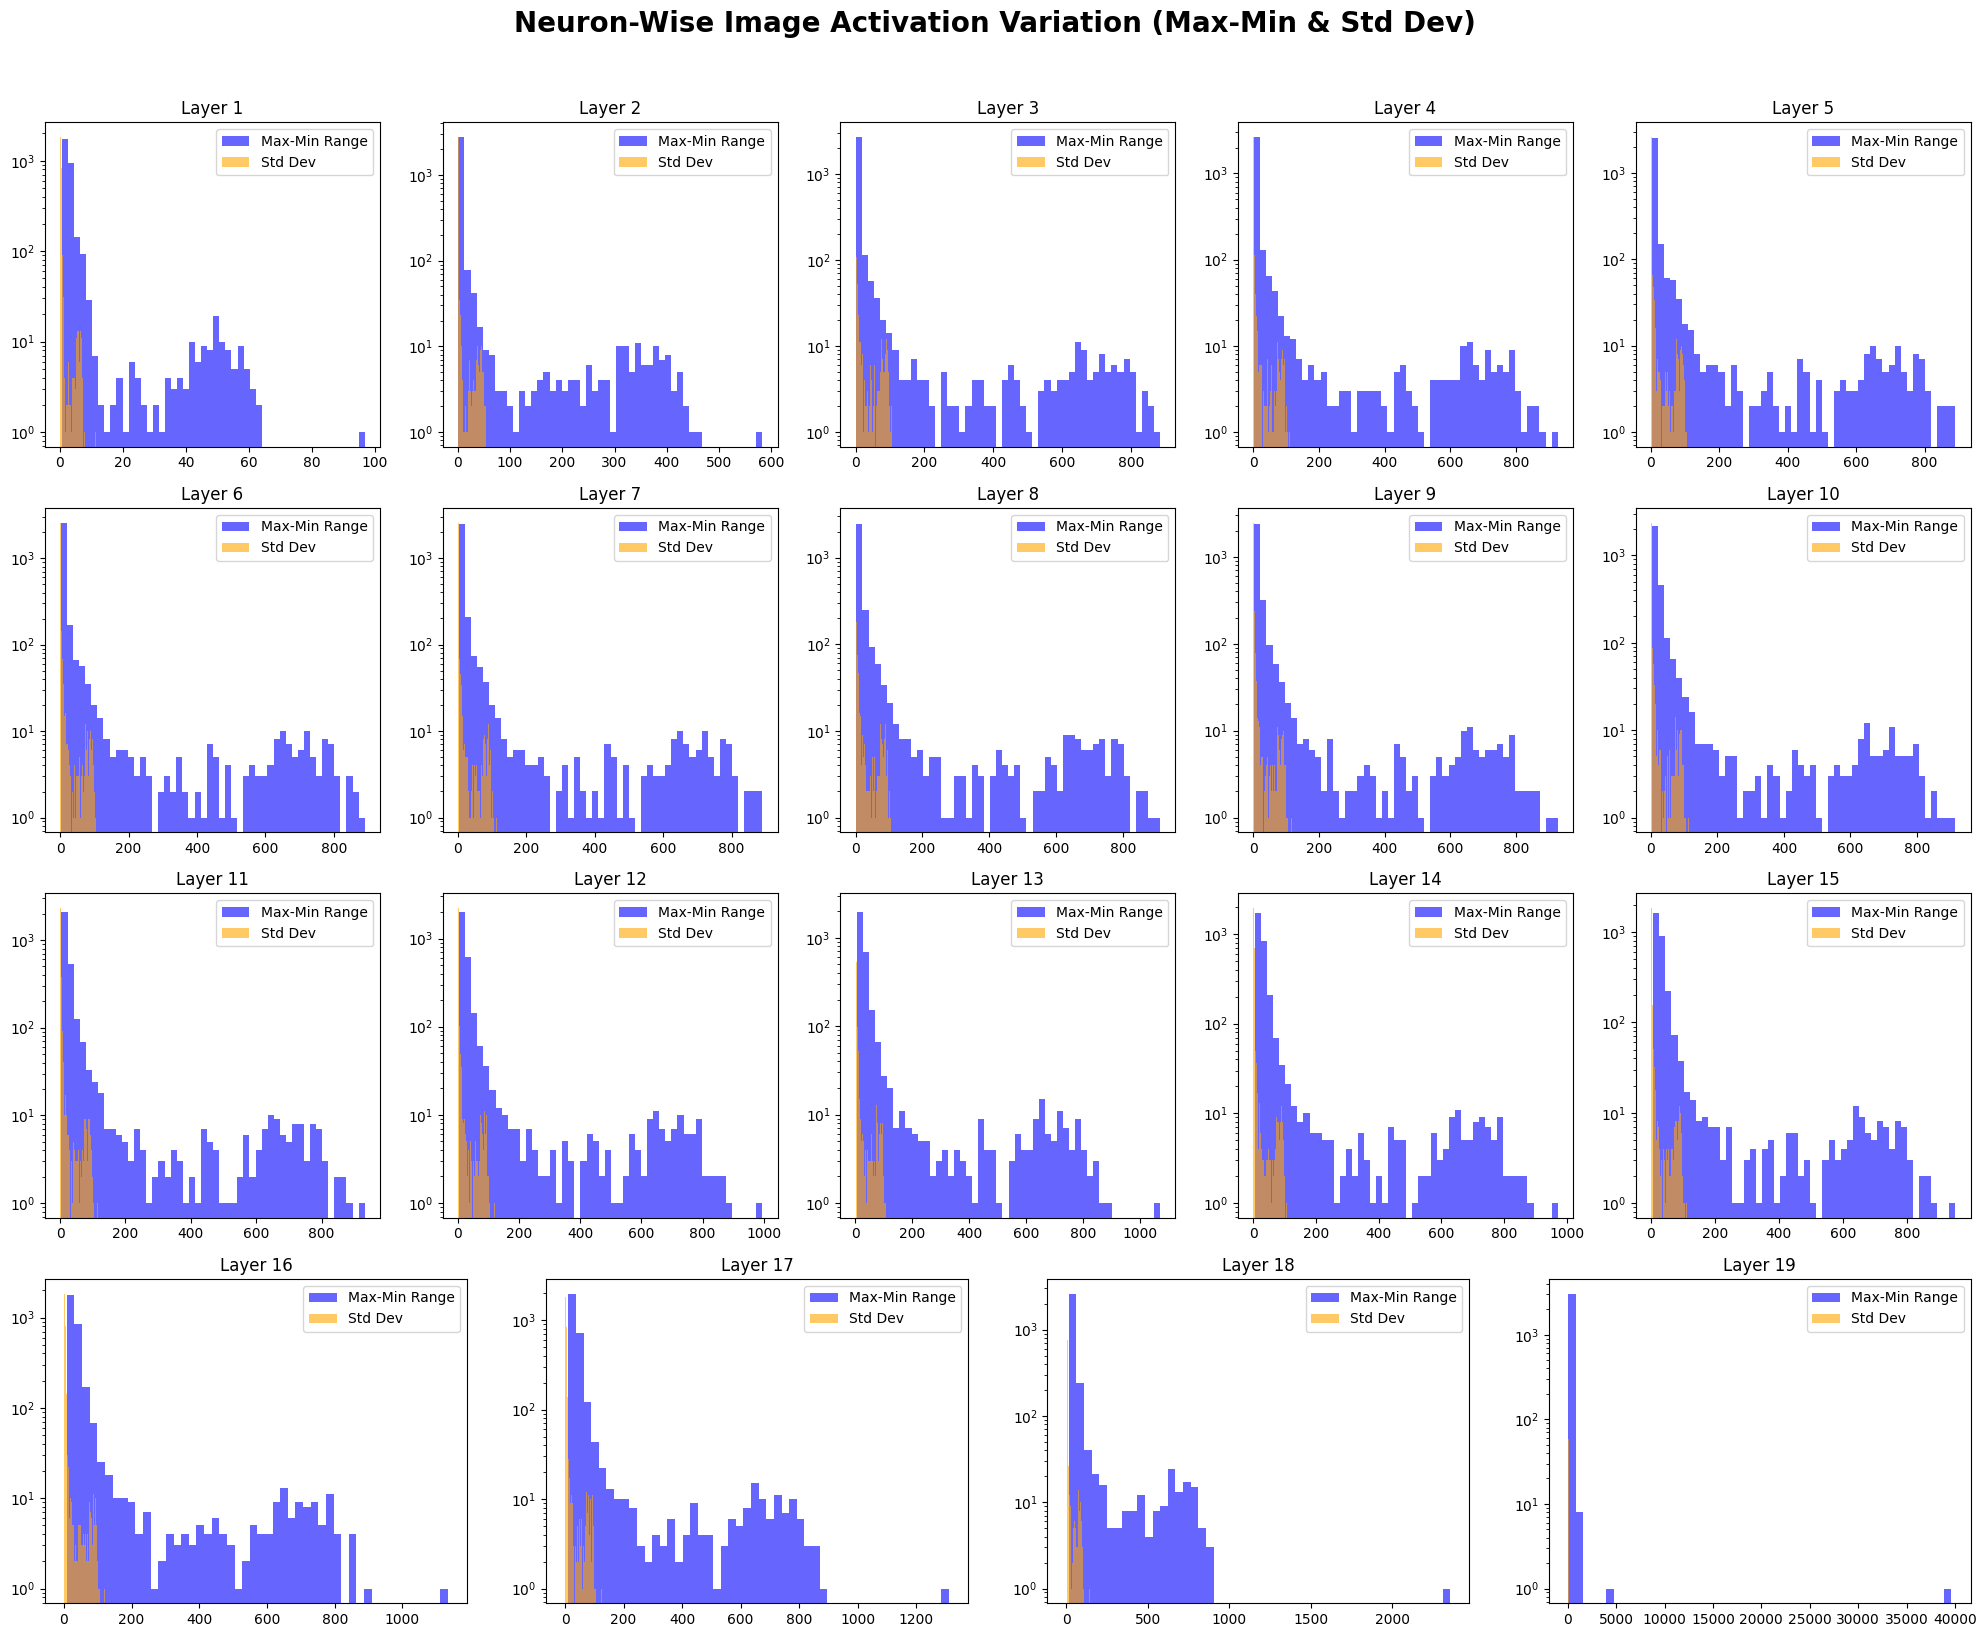

In [23]:
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(4, 5, figure=fig)

for i in range(15):
    image_select = image_layer_res[i].reshape(-1, image_layer_res.shape[-1]).to(t.float32).cpu().numpy()
    
    max_min_range = image_select.max(axis=0) - image_select.min(axis=0)
    std_dev = image_select.std(axis=0)

    ax = fig.add_subplot(gs[i // 5, i % 5])
    ax.hist(max_min_range, bins=50, alpha=0.6, label="Max-Min Range", color='blue', log=True)
    ax.hist(std_dev, bins=50, alpha=0.6, label="Std Dev", color='orange', log=True)
    ax.set_yscale('log')
    ax.set_title(f'Layer {i+1}')
    ax.legend()

    del image_select
    free_unused_cuda_memory()

last_row = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[3, 0:5])

for i in range(15, len(text_layer_res)):  
    image_select = image_layer_res[i].reshape(-1, image_layer_res.shape[-1]).to(t.float32).cpu().numpy()
    
    max_min_range = image_select.max(axis=0) - image_select.min(axis=0)
    std_dev = image_select.std(axis=0)

    ax = fig.add_subplot(last_row[0, i - 15])
    ax.hist(max_min_range, bins=50, alpha=0.6, label="Max-Min Range", color='blue', log=True)
    ax.hist(std_dev, bins=50, alpha=0.6, label="Std Dev", color='orange', log=True)
    ax.set_yscale('log')
    ax.set_title(f'Layer {i+1}')
    ax.legend()

    del image_select
    free_unused_cuda_memory()

fig.suptitle('Neuron-Wise Image Activation Variation (Max-Min & Std Dev)', fontsize=20, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

In [ ]:
# text_layer_res_np = text_layer_res.float().cpu().numpy()
# np.savez_compressed("data/schnell_text_layer_rez.npz", data=text_layer_res_np)
# del text_layer_res, text_layer_res_np
# free_unused_cuda_memory()

# image_layer_res_np = image_layer_res.float().cpu().numpy()
# np.savez_compressed("data/schnell_image_layer_rez.npz", data=image_layer_res_np)
# del image_layer_res, image_layer_res_np, pipe
# free_unused_cuda_memory()

## FLUX.1 Dev

In [10]:
from diffusers import FluxPipeline

pipe_dev = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=t.bfloat16, device_map="balanced")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
prompts_dataset = load_dataset("opendiffusionai/cc12m-cleaned", split="train").select(range(100))
prompts_iter = prompts_dataset["caption_llava_short"]

guidance_scale = 3.5
num_inference_steps = 1
batch_size = 32
width = 512
height = 512
d_model = 3072

for i, prompts in enumerate(chunked((bar := tqdm(prompts_iter)), batch_size)):
    with t.inference_mode():
        pipe.set_progress_bar_config(disable=True) 
        with t.inference_mode():
            latents = pipe(
                prompts,
                height=height,
                width=width,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps,
                max_sequence_length=512,
                generator=t.Generator("cpu").manual_seed(0),
                return_dict=False,
                callback_on_step_end=callback_on_step_end,
                output_type="latent",
            )[0]
    break

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
(
    prompt_embeds,
    pooled_prompt_embeds,
    text_ids,
) = pipe.encode_prompt(
    prompt=prompts,
    prompt_2=None,
    prompt_embeds=None,
    pooled_prompt_embeds=None,
    device=None,
    num_images_per_prompt=1,
    max_sequence_length=512,
    lora_scale=0.0,
)

In [ ]:
from tqdm import trange
from PIL import display
    
text_norms = defaultdict(list)
image_norms = defaultdict(list)
text_cossims = defaultdict(list)
image_cossims = defaultdict(list)
schnell_text = {}
schnell_image = {}


for m in pipe.transformer.modules():
    m._forward_hooks = OrderedDict()
for m in pipe_dev.transformer.modules():
    m._forward_hooks = OrderedDict()

def save_hook(self, input, output, l):
    text_output, image_output = output
    text_norm, image_norm = t.norm(text_output, dim=-1, p=2).mean(), t.norm(image_output, dim=-1, p=2).mean()
    key = (current_model, l, timestep)
    text_norms[key].append(text_norm.item())
    image_norms[key].append(image_norm.item())
    if l in schnell_image:
        other = schnell_image.pop(l).to(image_output.device)
        cossim = t.nn.functional.cosine_similarity(image_output.flatten(0, 1), other.flatten(0, -2), dim=-1).mean()
        image_cossims[l].append(cossim.item())
    if l in schnell_text:
        other = schnell_text.pop(l).to(text_output.device)
        cossim = t.nn.functional.cosine_similarity(text_output.flatten(0, 1), other.flatten(0, -2), dim=-1).mean()
        text_cossims[l].append(cossim.item())
    schnell_text[l] = text_output
    schnell_image[l] = image_output


for l in range(len(pipe.transformer.transformer_blocks)):
    pipe.transformer.transformer_blocks[l].register_forward_hook(partial(save_hook, l=l))
    pipe_dev.transformer.transformer_blocks[l].register_forward_hook(partial(save_hook, l=l))

with t.inference_mode():
    noise = t.randn_like(latents)
    guidance = t.tensor([3.5]).to(latents).expand(latents.shape[0])
    height_ = 2 * (int(height) // (pipe.vae_scale_factor * 2))
    width_ = 2 * (int(width) // (pipe.vae_scale_factor * 2))
    latent_image_ids = pipe._prepare_latent_image_ids(batch_size, height_ // 2, width_ // 2, latents.device, latents.dtype)
    num_test_steps = 6

    
    for i in trange(1, num_test_steps + 1):
        timestep = i / num_test_steps
        ts = t.tensor([timestep]).to(latents)
        mixed = (1 - ts) * latents + ts * noise

        @t.inference_mode
        def decode_latent(noise_pred, p):
            denoised = (mixed - ts * noise_pred) / (1 - ts)
            latents = p._unpack_latens(denoised, height, width, p.vae_scale_factor)
            latents = (latents / p.vae.config.scaling_factor) + p.vae.config.shift_factor
            image = p.vae.decode(latents, return_dict=False)[0]
            image = p.image_processor.postprocess(image, output_type="pil")
            return image[0]

        current_model = "schnell"
        noise_pred = pipe.transformer(
            mixed,
            timestep=ts,
            guidance=None,
            pooled_projections=pooled_prompt_embeds,
            encoder_hidden_states=prompt_embeds,
            txt_ids=text_ids,
            img_ids=latent_image_ids,
            joint_attention_kwargs=pipe.joint_attention_kwargs,
            return_dict=False,
        )
        current_model = "dev"
        pipe_dev.transformer(
            mixed,
            timestep=ts,
            guidance=guidance,
            pooled_projections=pooled_prompt_embeds,
            encoder_hidden_states=prompt_embeds,
            txt_ids=text_ids,
            img_ids=latent_image_ids,
            joint_attention_kwargs=pipe.joint_attention_kwargs,
            return_dict=False,
        )[0]
        display(decode_latent(noise_pred, pipe))


In [ ]:
# plots
# 1. norm over layer for different timesteps (different plots)
# 2. norm over timestep
# 3. cossim over layer for different timesteps (different plots)

In [ ]:
import matplotlib.pyplot as plt


for i in range(1, num_test_steps + 1):
    timestep = i / num_test_steps
    for model in ("schnell", "dev"):
        

{'text_norms': defaultdict(list,
             {('schnell', 0, 0.16666666666666666): [161.0],
              ('schnell', 1, 0.16666666666666666): [524.0],
              ('schnell', 2, 0.16666666666666666): [584.0],
              ('schnell', 3, 0.16666666666666666): [616.0],
              ('schnell', 4, 0.16666666666666666): [640.0],
              ('schnell', 5, 0.16666666666666666): [664.0],
              ('schnell', 6, 0.16666666666666666): [684.0],
              ('schnell', 7, 0.16666666666666666): [708.0],
              ('schnell', 8, 0.16666666666666666): [732.0],
              ('schnell', 9, 0.16666666666666666): [748.0],
              ('schnell', 10, 0.16666666666666666): [900.0],
              ('schnell', 11, 0.16666666666666666): [936.0],
              ('schnell', 12, 0.16666666666666666): [1096.0],
              ('schnell', 13, 0.16666666666666666): [1128.0],
              ('schnell', 14, 0.16666666666666666): [1384.0],
              ('schnell', 15, 0.16666666666666666): [1424.0